# Global Snow Sensor Classifications
plot area calculations for images processed in GEE

**Victoria Ly** (University of Washington)

***
#### Google Earth Engine: 
- [Global Sensor Classifications from Google Earth Engine](https://code.earthengine.google.com/9d87f13249d1d48a6f130e100c17f12a)

In [4]:
import xarray as xr
import rasterio as rio
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import rasterio.plot
import os
from datetime import datetime as dt
import matplotlib.dates as mdates

%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

In [44]:
# Set working directory
import os
os.chdir('C:\\Users\\vicki\\globalsnowmaps\\GlobSnow_SWE_monthly')
os.getcwd()

'C:\\Users\\vicki\\globalsnowmaps\\notebooks'

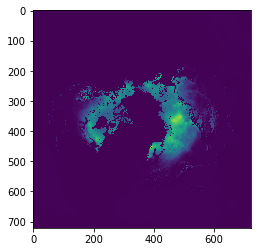

In [62]:
# Globsnow SWE for January [mm]
import rasterio
from matplotlib import pyplot

swemonth1 = "..\\GlobSnow_SWE_monthly/GlobSnow_SWE_L3B_month01_avg.tif"
src = rasterio.open(swemonth1)
pyplot.imshow(src.read(1), cmap='viridis')
pyplot.show()

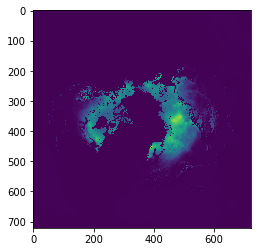

In [63]:
swemonth2 = "..\\GlobSnow_SWE_monthly/GlobSnow_SWE_L3B_month02_avg.tif"
src2 = rasterio.open(swemonth2)
pyplot.imshow(src2.read(1), cmap='viridis')

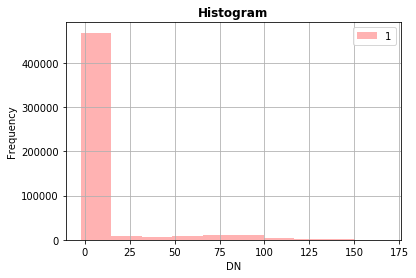

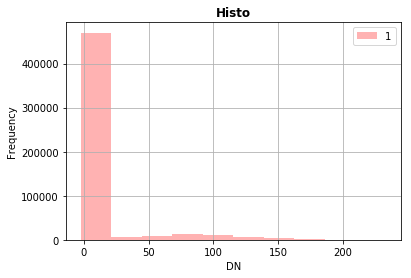

In [66]:
from rasterio.plot import show_hist
show_hist(src, bins=10, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram" )
show_hist(src2, bins=10, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histo")


***
### Set up Google Earth Engine API

In [68]:
# Import libraries.
import ee

from IPython.display import Image
import matplotlib.pyplot as plt
import rasterio

In [69]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Enter verification code: 4/vgFjcZaMr4nwHMmfZ7dwFcdGcHBIQ7X4nZ1deFhlQWFuR9PmT3NQ28k

Successfully saved authorization token.


In [ ]:
import ee
import numpy as np
from osgeo import gdal
from osgeo import osr
import time


In [70]:
# Define the roi
area = ee.Geometry.Polygon([[105.4084512289977,12.960956032145036],\
                            [105.46544280614614,12.960956032145036],\
                            [105.46544280614614,13.006454200439705],\
                            [105.4084512289977,13.006454200439705],\
                            [105.4084512289977,12.960956032145036]])
 
# define the image
collection = ee.ImageCollection("COPERNICUS/S2").filterBounds(area)\
                                      .filterDate("2018-01-01","2019-01-10")\
                                      .filterMetadata("CLOUDY_PIXEL_PERCENTAGE","less_than",10)\
                                      .select(['B8', 'B4'])
 
print(" number of image: ",collection.size().getInfo())
 


 number of image:  20


In [71]:
# perform any calculation on the image collection here
def anyFunction(img):
    ndvi = ee.Image(img.normalizedDifference(['B8', 'B4'])).rename(["ndvi"])
    return ndvi

In [72]:
# export the latitude, longitude and array
def LatLonImg(img):
    img = img.addBands(ee.Image.pixelLonLat())
 
    img = img.reduceRegion(reducer=ee.Reducer.toList(),\
                                        geometry=area,\
                                        maxPixels=1e13,\
                                        scale=10);
 
    data = np.array((ee.Array(img.get("result")).getInfo()))
    lats = np.array((ee.Array(img.get("latitude")).getInfo()))
    lons = np.array((ee.Array(img.get("longitude")).getInfo()))
    return lats, lons, data

In [73]:
# covert the lat, lon and array into an image
def toImage(lats,lons,data):
 
    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)
 
    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)
    nrows = len(uniqueLats)
 
    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0]
    xs = uniqueLons[1] - uniqueLons[0]
 
    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32) #-9999
 
    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner
    return arr
 


In [74]:
# map over the image collection
myCollection  = collection.map(anyFunction)

In [75]:
# get the median
result = ee.Image(myCollection.median()).rename(['result'])
 

In [76]:
# get the lon, lat and result as 1d array
lat, lon, data = LatLonImg(result)

In [77]:
# 1d to 2d array
image  = toImage(lat,lon,data)

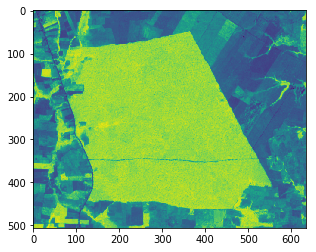

In [78]:
# in case you want to plot the image
import matplotlib.pyplot as plt
plt.imshow(image)
plt.show()